In [1]:
!pip install mlxtend


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\salij\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax, fpgrowth,association_rules
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
import seaborn as sns
from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

#Model libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score, learning_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix




In [32]:
data = pd.read_csv('Dataset.csv')

data
#data.info()
#data.isnull().sum()
#data['Address'].unique()

,Gender,Age at which Loan was Taken,Year of Application,A-levels,Education,Employment type,Current Employment Sector,Proposed Business Sector,Current Annual Income,Total Capital,Address,Refree Present,Refree 1,Refree 2,Refree 3,Loan Payment Failure
0,Q,40,2021,52,STEM,Self Business,IT,Civil,42499,26786,TUK,0,NaN,NaN,NaN,1
1,D,47,2017,48,Business,Salaried,IT,IT,79041,44691,TUK,0,NaN,NaN,NaN,0
2,C,44,2001,87,Law,Salaried,Agriculture,Agriculture,97381,31467,XYZ,0,NaN,NaN,NaN,1
3,P,43,2008,83,Law,Self Business,Civil,IT,79330,59948,MNP,0,NaN,NaN,NaN,0
4,Q,47,2004,67,STEM,Self Business,Civil,Agriculture,47105,39209,PQR,1,Salaried:45247,Contractual:47126,Salaried:140790,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,C,50,2016,84,Arts,Salaried,Agriculture,IT,73054,45737,GHI,1,Self Business:102881,Self Business:147488,Contractual:114161,0
40996,C,49,2003,55,Business,Self Business,Civil,IT,89375,42225,ABC,0,NaN,NaN,NaN,1
40997,P,44,2009,82,STEM,Salaried,Finance,Agriculture,44728,54907,ABC,1,Contractual:92248,Contractual:49216,Contractual:42324,1
40998,C,42,2020,48,STEM,Self Business,Finance,Civil,95895,38146,MNP,1,Salaried:121591,Self Business:42315,Contractual:106073,1


In [33]:
#Filling all NaN in refs 
data['Refree 1'].fillna('Not available', inplace=True)
data['Refree 2'].fillna('Not available', inplace=True)
data['Refree 3'].fillna('Not available', inplace=True)
data.isnull().sum()

Gender                         0
Age at which Loan was Taken    0
Year of Application            0
A-levels                       0
Education                      0
Employment type                0
Current Employment Sector      0
Proposed Business Sector       0
Current Annual Income          0
Total Capital                  0
Address                        0
Refree Present                 0
Refree 1                       0
Refree 2                       0
Refree 3                       0
Loan Payment Failure           0
dtype: int64

In [5]:
#counting the number of failed payments and loan payments in the data
failure_counts = data['Loan Payment Failure'].value_counts()
failure_counts
# failure_counts.plot(kind='bar')
# plt.title('Loan Payment Failure')
# plt.xlabel('Payment Status')
# plt.ylabel('Number of Applicants')
# plt.xticks(ticks=[0, 1], labels=['Paid', 'Failed'], rotation=0)
# plt.show()


Loan Payment Failure
1    20660
0    20340
Name: count, dtype: int64

In [6]:
#Descritinizing Age
data['Age at which Loan was Taken'].astype(str)
for i, row in data.iterrows():
    age = row['Age at which Loan was Taken']
    
    if int(age) >= 40 and int(age) < 50:
        data.at[i, 'Age Group'] = 'Fourties'
    elif int(age) >= 50:
        data.at[i, 'Age Group'] = 'Fifties'

C:\Users\salij\AppData\Local\Temp\ipykernel_18228\1949076945.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Fourties' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[i, 'Age Group'] = 'Fourties'


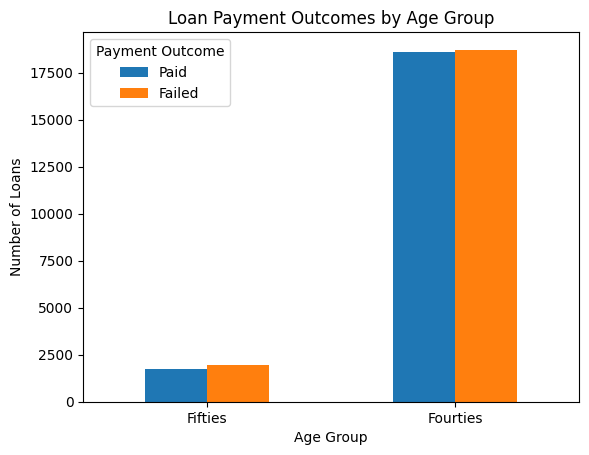

In [7]:
payment_outcomes = data.pivot_table(index='Age Group', columns='Loan Payment Failure', aggfunc='size', fill_value=0)
payment_outcomes.columns = ['Paid', 'Failed']
payment_outcomes.plot(kind='bar')
plt.title('Loan Payment Outcomes by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Number of Loans')
plt.xticks(rotation=0)
plt.legend(title='Payment Outcome')
plt.show()

In [8]:
#BINNING FOR YEARS 
cut_points = [1998, 2010, 2019, 2021, 2022] 
# DefinING the labels for the bins
labels = ['Low Years', 'Median Years', 'Covid Years', 'High Years']
# Bin the years
data['Year Bucket'] = pd.cut(data['Year of Application'], bins=cut_points, labels=labels, include_lowest=True)

C:\Users\salij\AppData\Local\Temp\ipykernel_18228\1112519122.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  yearly_payment_outcomes = data.groupby(['Year Bucket', 'Loan Payment Failure']).size().unstack(fill_value=0)


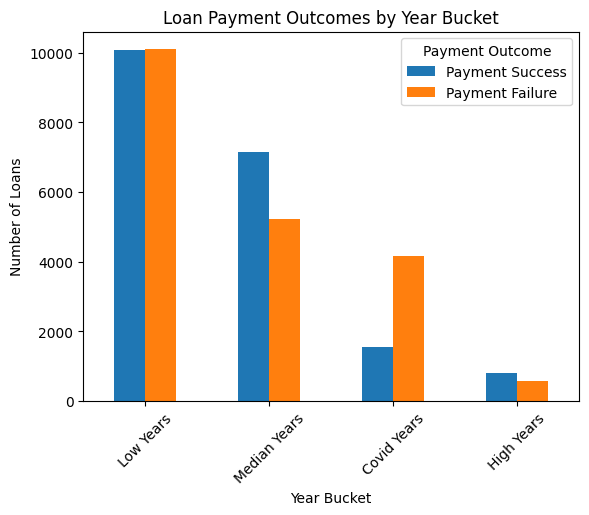

In [9]:
yearly_payment_outcomes = data.groupby(['Year Bucket', 'Loan Payment Failure']).size().unstack(fill_value=0)
yearly_payment_outcomes.columns = ['Payment Success', 'Payment Failure']
yearly_payment_outcomes.plot(kind='bar', stacked=False)
plt.title('Loan Payment Outcomes by Year Bucket')
plt.xlabel('Year Bucket')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Payment Outcome')
plt.show()

In [10]:
#BINNING FOR A-LEVEL SCORES
data['A-levels'] = data['A-levels'].astype(int)

for j, row in data.iterrows():
    scores = row['A-levels']
    
    if scores >= 40 and scores <= 49:
        data.at[j, 'Scores'] = 'Low score'
    elif scores >= 50 and scores <= 69:
        data.at[j, 'Scores'] = 'Medium score'
    elif scores >= 70:
        data.at[j, 'Scores'] = 'High score'

C:\Users\salij\AppData\Local\Temp\ipykernel_18228\2325416125.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Medium score' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[j, 'Scores'] = 'Medium score'


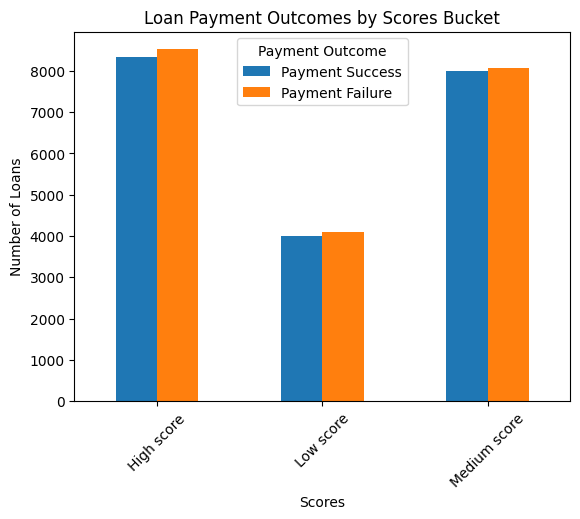

In [11]:
yearly_payment_outcomes = data.groupby(['Scores', 'Loan Payment Failure']).size().unstack(fill_value=0)
yearly_payment_outcomes.columns = ['Payment Success', 'Payment Failure']
yearly_payment_outcomes.plot(kind='bar', stacked=False)
plt.title('Loan Payment Outcomes by Scores Bucket')
plt.xlabel('Scores')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Payment Outcome')
plt.show()

In [12]:
#Descritinizing annual income
data['Current Annual Income'].astype(int)

for i, row in data.iterrows():
    income = row['Current Annual Income']
    
    if income >= 0 and income <= 25000:
        data.at[i, 'Annual Income'] = 'Low income'
    elif income > 25000 and income <= 95000:
        data.at[i, 'Annual Income'] = 'Medium income'
    elif income > 95000:
        data.at[i, 'Annual Income'] = 'High income'


C:\Users\salij\AppData\Local\Temp\ipykernel_18228\1521666055.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Medium income' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[i, 'Annual Income'] = 'Medium income'


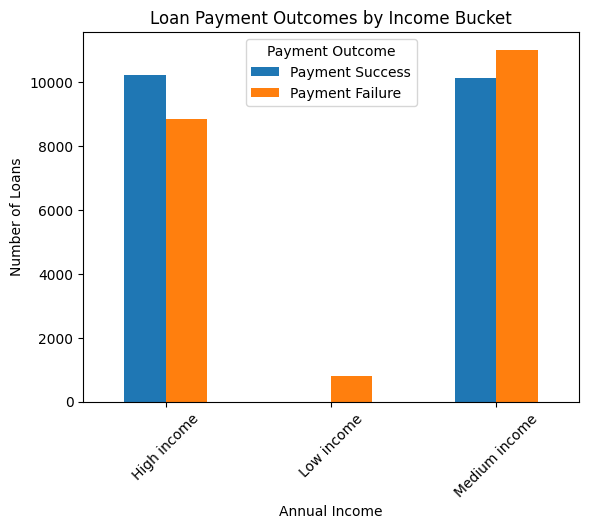

In [13]:
yearly_payment_outcomes = data.groupby(['Annual Income', 'Loan Payment Failure']).size().unstack(fill_value=0)
yearly_payment_outcomes.columns = ['Payment Success', 'Payment Failure']
yearly_payment_outcomes.plot(kind='bar', stacked=False)
plt.title('Loan Payment Outcomes by Income Bucket')
plt.xlabel('Annual Income')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Payment Outcome')
plt.show()

In [14]:
#BINNING FOR TOTAL CAPITAL 
data['Total Capital'].astype(int)

for i, row in data.iterrows():
    capital = row['Total Capital']
    
    if capital >= 0 and income <= 20000:
        data.at[i, 'Capital'] = 'Low capital'
    elif income > 20000 and income <= 50000:
        data.at[i, 'Capital'] = 'Medium capital'
    elif income > 50000:
        data.at[i, 'Capital'] = 'High  capital'


C:\Users\salij\AppData\Local\Temp\ipykernel_18228\1529455769.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Medium capital' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[i, 'Capital'] = 'Medium capital'


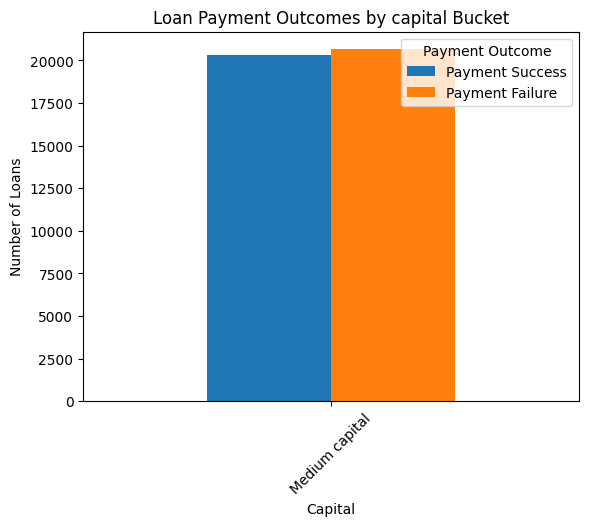

In [15]:
yearly_payment_outcomes = data.groupby(['Capital', 'Loan Payment Failure']).size().unstack(fill_value=0)
yearly_payment_outcomes.columns = ['Payment Success', 'Payment Failure']
yearly_payment_outcomes.plot(kind='bar', stacked=False)
plt.title('Loan Payment Outcomes by capital Bucket')
plt.xlabel('Capital')
plt.ylabel('Number of Loans')
plt.xticks(rotation=45)
plt.legend(title='Payment Outcome')
plt.show()

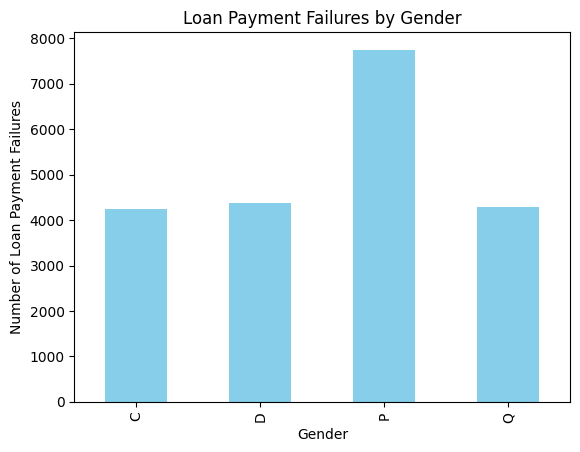

In [16]:
gender_groups = data.groupby('Gender')['Loan Payment Failure'].sum()
gender_groups.plot(kind='bar', color='skyblue')
plt.title('Loan Payment Failures by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Loan Payment Failures')

plt.show()

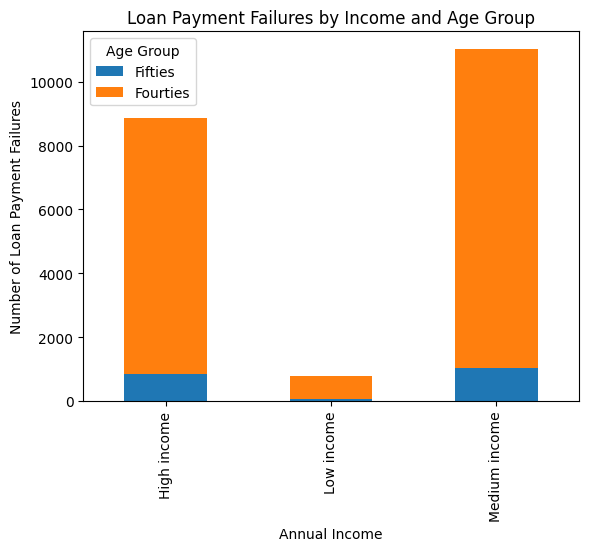

In [17]:
grouped_data = data.groupby(['Annual Income', 'Age Group'])['Loan Payment Failure'].sum().unstack()
grouped_data.plot(kind='bar', stacked=True)
plt.title('Loan Payment Failures by Income and Age Group')

plt.xlabel('Annual Income')
plt.ylabel('Number of Loan Payment Failures')

plt.legend(title='Age Group')

# Show the plot
plt.show()

In [18]:
#Feature engineering for contractual jobs in refs
data['number_contractual_jobs_in_refs'] = data.apply(lambda row: sum('Contractual' in refree for refree in row[['Refree 1', 'Refree 2', 'Refree 3']]), axis=1)
# Convert the new column to numeric type
data['number_contractual_jobs_in_refs'] = pd.to_numeric(data['number_contractual_jobs_in_refs'], errors='coerce')


#Feature engineering for self business jobs in refs
data['number_selfbusiness_jobs'] = data.apply(lambda row: sum('Self Business' in refree for refree in row[['Refree 1', 'Refree 2', 'Refree 3']]), axis=1)

# Convert the new column to numeric type
data['number_selfbusiness_jobs'] = pd.to_numeric(data['number_selfbusiness_jobs'], errors='coerce')

#Feature engineering for salaried jobs in refs
data['number_salaried'] = data.apply(lambda row: sum('Salaried' in refree for refree in row[['Refree 1', 'Refree 2', 'Refree 3']]), axis=1)

# Convert the new column to numeric type
data['number_salaried'] = pd.to_numeric(data['number_salaried'], errors='coerce')

data



,Gender,Age at which Loan was Taken,Year of Application,A-levels,Education,Employment type,Current Employment Sector,Proposed Business Sector,Current Annual Income,Total Capital,...,Refree 3,Loan Payment Failure,Age Group,Year Bucket,Scores,Annual Income,Capital,number_contractual_jobs_in_refs,number_selfbusiness_jobs,number_salaried
0,Q,40,2021,52,STEM,Self Business,IT,Civil,42499,26786,...,Not available,1,Fourties,Covid Years,Medium score,Medium income,Medium capital,0,0,0
1,D,47,2017,48,Business,Salaried,IT,IT,79041,44691,...,Not available,0,Fourties,Median Years,Low score,Medium income,Medium capital,0,0,0
2,C,44,2001,87,Law,Salaried,Agriculture,Agriculture,97381,31467,...,Not available,1,Fourties,Low Years,High score,High income,Medium capital,0,0,0
3,P,43,2008,83,Law,Self Business,Civil,IT,79330,59948,...,Not available,0,Fourties,Low Years,High score,Medium income,Medium capital,0,0,0
4,Q,47,2004,67,STEM,Self Business,Civil,Agriculture,47105,39209,...,Salaried:140790,0,Fourties,Low Years,Medium score,Medium income,Medium capital,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,C,50,2016,84,Arts,Salaried,Agriculture,IT,73054,45737,...,Contractual:114161,0,Fifties,Median Years,High score,Medium income,Medium capital,1,2,0
40996,C,49,2003,55,Business,Self Business,Civil,IT,89375,42225,...,Not available,1,Fourties,Low Years,Medium score,Medium income,Medium capital,0,0,0
40997,P,44,2009,82,STEM,Salaried,Finance,Agriculture,44728,54907,...,Contractual:42324,1,Fourties,Low Years,High score,Medium income,Medium capital,3,0,0
40998,C,42,2020,48,STEM,Self Business,Finance,Civil,95895,38146,...,Contractual:106073,1,Fourties,Covid Years,Low score,High income,Medium capital,1,1,1


In [19]:
# Extracting salarie amount from the tuple
salaries = data[['Refree 1', 'Refree 2', 'Refree 3']].apply(lambda row: [int(val.split(':')[1]) for val in row if 'Salaried' in val], axis=1)

# Categorize salaries into buckets
data['high_salary'] = salaries.apply(lambda salary_list: sum(salary >= 90000 for salary in salary_list))
data['medium_salary'] = salaries.apply(lambda salary_list: sum(50000 <= salary <= 89999 for salary in salary_list))
data['low_salary'] = salaries.apply(lambda salary_list: sum(salary <= 49999 for salary in salary_list))

# Print the updated DataFrame
pd.set_option('display.max_columns', None)
data

,Gender,Age at which Loan was Taken,Year of Application,A-levels,Education,Employment type,Current Employment Sector,Proposed Business Sector,Current Annual Income,Total Capital,Address,Refree Present,Refree 1,Refree 2,Refree 3,Loan Payment Failure,Age Group,Year Bucket,Scores,Annual Income,Capital,number_contractual_jobs_in_refs,number_selfbusiness_jobs,number_salaried,high_salary,medium_salary,low_salary
0,Q,40,2021,52,STEM,Self Business,IT,Civil,42499,26786,TUK,0,Not available,Not available,Not available,1,Fourties,Covid Years,Medium score,Medium income,Medium capital,0,0,0,0,0,0
1,D,47,2017,48,Business,Salaried,IT,IT,79041,44691,TUK,0,Not available,Not available,Not available,0,Fourties,Median Years,Low score,Medium income,Medium capital,0,0,0,0,0,0
2,C,44,2001,87,Law,Salaried,Agriculture,Agriculture,97381,31467,XYZ,0,Not available,Not available,Not available,1,Fourties,Low Years,High score,High income,Medium capital,0,0,0,0,0,0
3,P,43,2008,83,Law,Self Business,Civil,IT,79330,59948,MNP,0,Not available,Not available,Not available,0,Fourties,Low Years,High score,Medium income,Medium capital,0,0,0,0,0,0
4,Q,47,2004,67,STEM,Self Business,Civil,Agriculture,47105,39209,PQR,1,Salaried:45247,Contractual:47126,Salaried:140790,0,Fourties,Low Years,Medium score,Medium income,Medium capital,1,0,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,C,50,2016,84,Arts,Salaried,Agriculture,IT,73054,45737,GHI,1,Self Business:102881,Self Business:147488,Contractual:114161,0,Fifties,Median Years,High score,Medium income,Medium capital,1,2,0,0,0,0
40996,C,49,2003,55,Business,Self Business,Civil,IT,89375,42225,ABC,0,Not available,Not available,Not available,1,Fourties,Low Years,Medium score,Medium income,Medium capital,0,0,0,0,0,0
40997,P,44,2009,82,STEM,Salaried,Finance,Agriculture,44728,54907,ABC,1,Contractual:92248,Contractual:49216,Contractual:42324,1,Fourties,Low Years,High score,Medium income,Medium capital,3,0,0,0,0,0
40998,C,42,2020,48,STEM,Self Business,Finance,Civil,95895,38146,MNP,1,Salaried:121591,Self Business:42315,Contractual:106073,1,Fourties,Covid Years,Low score,High income,Medium capital,1,1,1,1,0,0


In [20]:
#DSTORING ALL THE PREPROCESSED AND ENGINEERED AND DROPPING OLD DATA FROM ORIGINAL DATASET
new_data = data.drop(['Age at which Loan was Taken','Year of Application','A-levels','Current Annual Income','Total Capital','Refree 1','Refree 2','Refree 3'], axis=1)
new_data.columns = new_data.columns.str.replace(' ', '_')

pd.set_option('display.max_columns', None)
new_data

,Gender,Education,Employment_type,Current_Employment_Sector,Proposed_Business_Sector,Address,Refree_Present,Loan_Payment_Failure,Age_Group,Year_Bucket,Scores,Annual_Income,Capital,number_contractual_jobs_in_refs,number_selfbusiness_jobs,number_salaried,high_salary,medium_salary,low_salary
0,Q,STEM,Self Business,IT,Civil,TUK,0,1,Fourties,Covid Years,Medium score,Medium income,Medium capital,0,0,0,0,0,0
1,D,Business,Salaried,IT,IT,TUK,0,0,Fourties,Median Years,Low score,Medium income,Medium capital,0,0,0,0,0,0
2,C,Law,Salaried,Agriculture,Agriculture,XYZ,0,1,Fourties,Low Years,High score,High income,Medium capital,0,0,0,0,0,0
3,P,Law,Self Business,Civil,IT,MNP,0,0,Fourties,Low Years,High score,Medium income,Medium capital,0,0,0,0,0,0
4,Q,STEM,Self Business,Civil,Agriculture,PQR,1,0,Fourties,Low Years,Medium score,Medium income,Medium capital,1,0,2,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,C,Arts,Salaried,Agriculture,IT,GHI,1,0,Fifties,Median Years,High score,Medium income,Medium capital,1,2,0,0,0,0
40996,C,Business,Self Business,Civil,IT,ABC,0,1,Fourties,Low Years,Medium score,Medium income,Medium capital,0,0,0,0,0,0
40997,P,STEM,Salaried,Finance,Agriculture,ABC,1,1,Fourties,Low Years,High score,Medium income,Medium capital,3,0,0,0,0,0
40998,C,STEM,Self Business,Finance,Civil,MNP,1,1,Fourties,Covid Years,Low score,High income,Medium capital,1,1,1,1,0,0


In [21]:
#ONE HOT ENCODING
encoded_data = pd.get_dummies(new_data)


#NORMALISATION USING STANDARD SCALER
scaler = StandardScaler()
scaler.fit(encoded_data)
norm_data_scaled = pd.DataFrame(scaler.transform(encoded_data), columns=encoded_data.columns)
norm_data_scaled

,Refree_Present,Loan_Payment_Failure,number_contractual_jobs_in_refs,number_selfbusiness_jobs,number_salaried,high_salary,medium_salary,low_salary,Gender_C,Gender_D,Gender_P,Gender_Q,Education_Arts,Education_Business,Education_Law,Education_STEM,Employment_type_Contractual,Employment_type_Salaried,Employment_type_Self Business,Current_Employment_Sector_Agriculture,Current_Employment_Sector_Civil,Current_Employment_Sector_Finance,Current_Employment_Sector_IT,Proposed_Business_Sector_Agriculture,Proposed_Business_Sector_Civil,Proposed_Business_Sector_Finance,Proposed_Business_Sector_IT,Address_ABC,Address_GHI,Address_MNP,Address_PQR,Address_TUK,Address_XYZ,Age_Group_Fifties,Age_Group_Fourties,Year_Bucket_Low Years,Year_Bucket_Median Years,Year_Bucket_Covid Years,Year_Bucket_High Years,Scores_High score,Scores_Low score,Scores_Medium score,Annual_Income_High income,Annual_Income_Low income,Annual_Income_Medium income,Capital_Medium capital
0,-1.148422,0.992225,-0.734317,-0.700896,-0.651276,-0.452562,-0.372207,-0.289458,-0.543976,-0.544654,-0.675444,1.831851,-0.571830,-0.583133,-0.580317,1.741794,-0.747858,-0.628365,1.338430,-0.578965,-0.580993,-0.575998,1.743847,-0.549922,1.512839,-0.546573,-0.552254,-0.466042,-0.463637,-0.429844,-0.429485,2.340756,-0.466313,-0.314720,0.314720,-0.983646,-0.657849,2.484774,-0.18621,-0.835719,-0.495613,1.246484,-0.932287,-0.140348,0.969111,0.0
1,-1.148422,-1.007836,-0.734317,-0.700896,-0.651276,-0.452562,-0.372207,-0.289458,-0.543976,1.836029,-0.675444,-0.545896,-0.571830,1.714874,-0.580317,-0.574121,-0.747858,1.591432,-0.747144,-0.578965,-0.580993,-0.575998,1.743847,-0.549922,-0.661009,-0.546573,1.810761,-0.466042,-0.463637,-0.429844,-0.429485,2.340756,-0.466313,-0.314720,0.314720,-0.983646,1.520106,-0.402451,-0.18621,-0.835719,2.017702,-0.802257,-0.932287,-0.140348,0.969111,0.0
2,-1.148422,0.992225,-0.734317,-0.700896,-0.651276,-0.452562,-0.372207,-0.289458,1.838316,-0.544654,-0.675444,-0.545896,-0.571830,-0.583133,1.723197,-0.574121,-0.747858,1.591432,-0.747144,1.727220,-0.580993,-0.575998,-0.573445,1.818440,-0.661009,-0.546573,-0.552254,-0.466042,-0.463637,-0.429844,-0.429485,-0.427212,2.144481,-0.314720,0.314720,1.016626,-0.657849,-0.402451,-0.18621,1.196575,-0.495613,-0.802257,1.072631,-0.140348,-1.031874,0.0
3,-1.148422,-1.007836,-0.734317,-0.700896,-0.651276,-0.452562,-0.372207,-0.289458,-0.543976,-0.544654,1.480508,-0.545896,-0.571830,-0.583133,1.723197,-0.574121,-0.747858,-0.628365,1.338430,-0.578965,1.721192,-0.575998,-0.573445,-0.549922,-0.661009,-0.546573,1.810761,-0.466042,-0.463637,2.326427,-0.429485,-0.427212,-0.466313,-0.314720,0.314720,1.016626,-0.657849,-0.402451,-0.18621,1.196575,-0.495613,-0.802257,-0.932287,-0.140348,0.969111,0.0
4,0.870760,-1.007836,0.354268,-0.700896,1.969809,1.481261,-0.372207,2.279323,-0.543976,-0.544654,-0.675444,1.831851,-0.571830,-0.583133,-0.580317,1.741794,-0.747858,-0.628365,1.338430,-0.578965,1.721192,-0.575998,-0.573445,1.818440,-0.661009,-0.546573,-0.552254,-0.466042,-0.463637,-0.429844,2.328369,-0.427212,-0.466313,-0.314720,0.314720,1.016626,-0.657849,-0.402451,-0.18621,-0.835719,-0.495613,1.246484,-0.932287,-0.140348,0.969111,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,0.870760,-1.007836,0.354268,1.920471,-0.651276,-0.452562,-0.372207,-0.289458,1.838316,-0.544654,-0.675444,-0.545896,1.748771,-0.583133,-0.580317,-0.574121,-0.747858,1.591432,-0.747144,1.727220,-0.580993,-0.575998,-0.573445,-0.549922,-0.661009,-0.546573,1.810761,-0.466042,2.156862,-0.429844,-0.429485,-0.427212,-0.466313,3.177432,-3.177432,-0.983646,1.520106,-0.402451,-0.18621,1.196575,-0.495613,-0.802257,-0.932287,-0.140348,0.969111,0.0
40996,-1.148422,0.992225,-0.734317,-0.700896,-0.651276,-0.452562,-0.372207,-0.289458,1.838316,-0.544654,-0.675444,-0.545896,-0.571830,1.714874,-0.580317,-0.574121,-0.747858,-0.628365,1.338430,-0.57

In [22]:
encoded_data

,Refree_Present,Loan_Payment_Failure,number_contractual_jobs_in_refs,number_selfbusiness_jobs,number_salaried,high_salary,medium_salary,low_salary,Gender_C,Gender_D,Gender_P,Gender_Q,Education_Arts,Education_Business,Education_Law,Education_STEM,Employment_type_Contractual,Employment_type_Salaried,Employment_type_Self Business,Current_Employment_Sector_Agriculture,Current_Employment_Sector_Civil,Current_Employment_Sector_Finance,Current_Employment_Sector_IT,Proposed_Business_Sector_Agriculture,Proposed_Business_Sector_Civil,Proposed_Business_Sector_Finance,Proposed_Business_Sector_IT,Address_ABC,Address_GHI,Address_MNP,Address_PQR,Address_TUK,Address_XYZ,Age_Group_Fifties,Age_Group_Fourties,Year_Bucket_Low Years,Year_Bucket_Median Years,Year_Bucket_Covid Years,Year_Bucket_High Years,Scores_High score,Scores_Low score,Scores_Medium score,Annual_Income_High income,Annual_Income_Low income,Annual_Income_Medium income,Capital_Medium capital
0,0,1,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,True
1,0,0,0,0,0,0,0,0,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,True,True
2,0,1,0,0,0,0,0,0,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,True,False,False,True
3,0,0,0,0,0,0,0,0,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True,True,False,False,False,True,False,False,False,False,True,True
4,1,0,1,0,2,1,0,1,False,False,False,True,False,False,False,True,False,False,True,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False,True,True,False,False,False,False,False,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40995,1,0,1,2,0,0,0,0,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False,False,False,True,True
40996,0,1,0,0,0,0,0,0,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,True
40997,1,1,3,0,0,0,0,0,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,True,True
40998,1,1,1,1,1,1,0,0,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,True


In [14]:
#INITIAL DATA EXPLO

In [23]:
# Apply Apriori algorithm to find frequent itemsets
apri_data = encoded_data.drop(['number_contractual_jobs_in_refs','number_selfbusiness_jobs','number_salaried','high_salary','medium_salary','low_salary'], axis=1)
payment_1 = apri_data[apri_data['Loan_Payment_Failure'] == 1]
payment_drop = payment_1.drop(['Loan_Payment_Failure'], axis=1)
frequent_itemsets = apriori(payment_drop,  use_colnames=True, min_support=0.1)

# Display the frequent itemsets and association rules
print("Frequent Itemsets:")
print(frequent_itemsets)
#frequent_itemsets.head(50)

C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent Itemsets:
      support                                           itemsets
0    0.641578                                   (Refree_Present)
1    0.206002                                         (Gender_C)
2    0.211665                                         (Gender_D)
3    0.375121                                         (Gender_P)
4    0.207212                                         (Gender_Q)
..        ...                                                ...
650       0.1  (Age_Group_Fourties, Refree_Present, Annual_In...
651  0.117473  (Age_Group_Fourties, Refree_Present, Annual_In...
652  0.112633  (Age_Group_Fourties, Employment_type_Contractu...
653  0.135963  (Age_Group_Fourties, Proposed_Business_Sector_...
654  0.101016  (Scores_High score, Age_Group_Fourties, Annual...

[655 rows x 2 columns]


In [24]:
#ASSOCIATION RULE MINING
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
rules = association_rules(frequent_itemsets, metric="confidence" )#min_threshol1005
#pd.set_option('display.max_columns', None)
#rules.head(50)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Refree_Present),(Age_Group_Fourties),0.641578,0.906147,0.581317,0.906073,0.999918,-0.000047,0.999213,-0.000228
1,(Refree_Present),(Capital_Medium capital),0.641578,1.000000,0.641578,1.000000,1.000000,0.000000,inf,0.000000
2,(Gender_C),(Age_Group_Fourties),0.206002,0.906147,0.185624,0.901081,0.994409,-0.001044,0.948783,-0.007031
3,(Gender_C),(Capital_Medium capital),0.206002,1.000000,0.206002,1.000000,1.000000,0.000000,inf,0.000000
4,(Gender_D),(Age_Group_Fourties),0.211665,0.906147,0.192933,0.911502,1.005910,0.001134,1.060513,0.007453
...,...,...,...,...,...,...,...,...,...,...
782,"(Proposed_Business_Sector_Civil, Year_Bucket_C...","(Capital_Medium capital, Age_Group_Fourties, E...",0.159487,0.346563,0.135963,0.852504,2.459878,0.080691,4.430193,0.706088
783,"(Year_Bucket_Covid Years, Employment_type_Self...","(Capital_Medium capital, Proposed_Business_Sec...",0.159439,0.323669,0.135963,0.852763,2.634676,0.084358,4.593473,0.738134
784,"(Annual_Income_Medium income, Scores_High scor...",(Capital_Medium capital),0.101016,1.000000,0.101016,1.000000,1.000000,0.000000,inf,0.000000
785,"(Capital_Medium capital, Annual_Income_Medium ...",(Age_Group_Fourties),0.111471,0.906147,0.101016,0.906209,1.000069,0.000007,1.000663,0.000077


In [28]:
#k-MEDOID CLUSTERS

payment_1_km = encoded_data[encoded_data['Loan_Payment_Failure'] == 1]
km_data = payment_1_km.reset_index(drop=True)

# precompute the distances using cosine metric
distance_matrix = pairwise_distances(km_data, metric='hamming')
#sns.heatmap(distance_matrix)
#np.isnan(distance_matrix)
#np.count_nonzero(np.isnan(distance_matrix))

modelkm = KMedoids(n_clusters=4, metric='precomputed', random_state=0)
km = modelkm.fit(distance_matrix)
print(km.labels_)
print(km.inertia_)
cluslabels = pd.DataFrame(km.labels_,columns=['Cluster ID'])
result = pd.concat((km_data,cluslabels), axis=1)
result

[0 2 3 ... 3 1 0]
5312.434782608696


,Refree_Present,Loan_Payment_Failure,number_contractual_jobs_in_refs,number_selfbusiness_jobs,number_salaried,high_salary,medium_salary,low_salary,Gender_C,Gender_D,Gender_P,Gender_Q,Education_Arts,Education_Business,Education_Law,Education_STEM,Employment_type_Contractual,Employment_type_Salaried,Employment_type_Self Business,Current_Employment_Sector_Agriculture,Current_Employment_Sector_Civil,Current_Employment_Sector_Finance,Current_Employment_Sector_IT,Proposed_Business_Sector_Agriculture,Proposed_Business_Sector_Civil,Proposed_Business_Sector_Finance,Proposed_Business_Sector_IT,Address_ABC,Address_GHI,Address_MNP,Address_PQR,Address_TUK,Address_XYZ,Age_Group_Fifties,Age_Group_Fourties,Year_Bucket_Low Years,Year_Bucket_Median Years,Year_Bucket_Covid Years,Year_Bucket_High Years,Scores_High score,Scores_Low score,Scores_Medium score,Annual_Income_High income,Annual_Income_Low income,Annual_Income_Medium income,Capital_Medium capital,Cluster ID
0,0,1,0,0,0,0,0,0,False,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True,False,False,False,True,False,False,True,True,0
1,0,1,0,0,0,0,0,0,True,False,False,False,False,False,True,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,True,False,False,True,2
2,1,1,1,0,2,0,0,2,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,True,False,True,False,False,True,3
3,1,1,3,0,0,0,0,0,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False,True,False,False,False,True,False,True,False,False,True,0
4,1,1,1,2,0,0,0,0,False,True,False,False,False,False,False,True,True,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,True,False,False,True,False,False,True,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20655,0,1,0,0,0,0,0,0,False,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,True,True,False,False,True,1
20656,0,1,0,0,0,0,0,0,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,True,True,False,False,False,True,False,True,1
20657,0,1,0,0,0,0,0,0,True,False,False,False,False,True,False,False,False,False,True,False,True,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,False,False,False,False,False,True,False,False,True,True,3
20658,1,1,3,0,0,0,0,0,False,False,True,False,False,False,False,True,False,True,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,True,True,1


In [29]:
#K-MEDOID LARGE CLUSTER WITH APRIORI

cluster_sizes = result.groupby('Cluster ID').size()
print(cluster_sizes)
large_cluster_threshold = 3000
large_clusters = cluster_sizes[cluster_sizes > large_cluster_threshold]
#print(large_clusters)
large_cluster_ids = large_clusters.index

large_cluster_data = result[result['Cluster ID'].isin(large_cluster_ids)]

aprik_data = large_cluster_data.drop(['number_contractual_jobs_in_refs','number_selfbusiness_jobs','number_salaried','high_salary','medium_salary','low_salary', 'Cluster ID'], axis=1)

paymentk_1 = aprik_data[aprik_data['Loan_Payment_Failure'] == 1]
paymentk_drop = paymentk_1.drop(['Loan_Payment_Failure'], axis=1)
frequentk_itemsets = apriori(paymentk_drop,  use_colnames=True, min_support=0.1)#

# # Display the frequent itemsets and association rules
print("Frequent Itemsets:")
print(frequentk_itemsets)

frequentk_itemsets['length'] = frequentk_itemsets['itemsets'].apply(lambda x: len(x))
rules = association_rules(frequentk_itemsets, metric="confidence" )#min_threshold=0.5
rules

Cluster ID
0    6604
1    4242
2    5321
3    4493
dtype: int64


C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\mlxtend\frequent_patterns\fpcommon.py:110: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Frequent Itemsets:
      support                                           itemsets
0    0.641578                                   (Refree_Present)
1    0.206002                                         (Gender_C)
2    0.211665                                         (Gender_D)
3    0.375121                                         (Gender_P)
4    0.207212                                         (Gender_Q)
..        ...                                                ...
650       0.1  (Age_Group_Fourties, Refree_Present, Annual_In...
651  0.117473  (Age_Group_Fourties, Refree_Present, Annual_In...
652  0.112633  (Age_Group_Fourties, Employment_type_Contractu...
653  0.135963  (Age_Group_Fourties, Proposed_Business_Sector_...
654  0.101016  (Scores_High score, Age_Group_Fourties, Annual...

[655 rows x 2 columns]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(Refree_Present),(Age_Group_Fourties),0.641578,0.906147,0.581317,0.906073,0.999918,-0.000047,0.999213,-0.000228
1,(Refree_Present),(Capital_Medium capital),0.641578,1.000000,0.641578,1.000000,1.000000,0.000000,inf,0.000000
2,(Gender_C),(Age_Group_Fourties),0.206002,0.906147,0.185624,0.901081,0.994409,-0.001044,0.948783,-0.007031
3,(Gender_C),(Capital_Medium capital),0.206002,1.000000,0.206002,1.000000,1.000000,0.000000,inf,0.000000
4,(Gender_D),(Age_Group_Fourties),0.211665,0.906147,0.192933,0.911502,1.005910,0.001134,1.060513,0.007453
...,...,...,...,...,...,...,...,...,...,...
782,"(Proposed_Business_Sector_Civil, Year_Bucket_C...","(Capital_Medium capital, Age_Group_Fourties, E...",0.159487,0.346563,0.135963,0.852504,2.459878,0.080691,4.430193,0.706088
783,"(Year_Bucket_Covid Years, Employment_type_Self...","(Capital_Medium capital, Proposed_Business_Sec...",0.159439,0.323669,0.135963,0.852763,2.634676,0.084358,4.593473,0.738134
784,"(Annual_Income_Medium income, Scores_High scor...",(Capital_Medium capital),0.101016,1.000000,0.101016,1.000000,1.000000,0.000000,inf,0.000000
785,"(Capital_Medium capital, Annual_Income_Medium ...",(Age_Group_Fourties),0.111471,0.906147,0.101016,0.906209,1.000069,0.000007,1.000663,0.000077


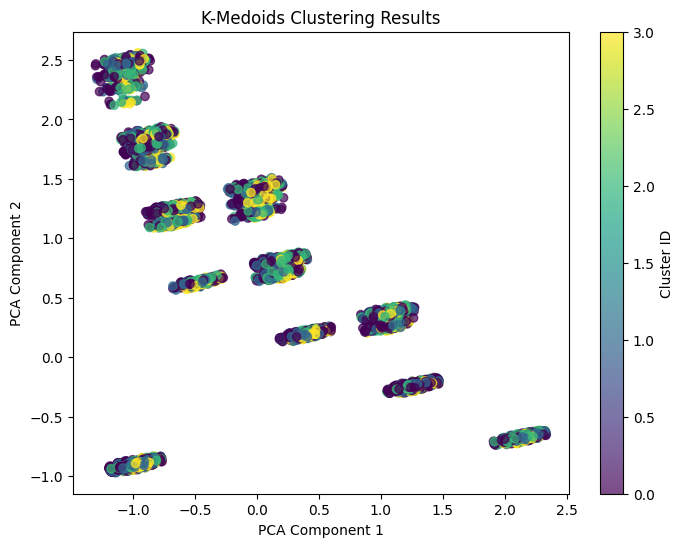

In [34]:
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
pca_result = pca.fit_transform(km_data)
result['PCA1'] = pca_result[:, 0]
result['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
plt.scatter(result['PCA1'], result['PCA2'], c=result['Cluster ID'], cmap='viridis', marker='o', alpha=0.7)


plt.title('K-Medoids Clustering Results')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster ID')
plt.show()

In [128]:
#DECISION TREE CLASSIFIER with a Grid search and Cross validation of k-fold 5


X = encoded_data.drop(['Loan_Payment_Failure'], axis=1)
y = encoded_data.iloc[:, 1]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#parameter grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 4, 5, 6],
    'random_state': [42],
    'min_samples_split':[2,5,10]
}

model = DecisionTreeClassifier()

#grid search object with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)

#Fitting grid search to the training data
#grid_search.fit(X_train, y_train)
grid_search.fit(X, y)
best_params = grid_search.best_params_

dt_clf = DecisionTreeClassifier(**best_params)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

best_score = grid_search.best_score_

#Evaluating the model on the test data
score = grid_search.score(X_test, y_test)
model_score = dt_clf.score(X_test, y_test)

print("Best Parameters:", best_params)
print("Best Score:", best_score)
print("Test Score:", score)
print("model score:", model_score)
print(f1_score(y_test, dt_pred))

print(confusion_matrix(y_test, dt_pred), ": is the confusion matrix")


Best Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 5, 'random_state': 42}
Best Score: 0.7115365853658536
Test Score: 0.7146341463414634
model score: 0.7140243902439024
0.6788990825688075
[[3376  703]
 [1642 2479]] : is the confusion matrix


In [48]:
#NAIVE BAYES 

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

nb_clf = GaussianNB()

# cross-validation on the model and grid search
grid_search = GridSearchCV(nb_clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

nb_clf = GaussianNB(**best_params)
nb_clf.fit(X_train, y_train)

# Make predictions on the test data
Nb_pred = nb_clf.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, Nb_pred)

print("Cross-Validation Scores:", cv_scores)
print("Accuracy Score:", accuracy)
print(confusion_matrix(y_test, Nb_pred), ": is the confusion matrix")

Best Parameters: {'var_smoothing': 1e-06}
Cross-Validation Scores: [0.7160061  0.72713415 0.73018293 0.7195122  0.71905488]
Accuracy Score: 0.5640243902439024
[[3988  129]
 [3446  637]] : is the confusion matrix


In [49]:
# RANDOM FOREST CLASSIFIER 

param_grid = {
    'n_estimators': [20, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [42]
}


rf_clf = RandomForestClassifier()
grid_search = GridSearchCV(rf_clf, param_grid, cv=5)

#grid_search.fit(X_train, y_train)
grid_search.fit(X, y)
# Get the best parameters
best_params = grid_search.best_params_

rf_clf_best = RandomForestClassifier(**best_params)

#cross-validation on the training data
cv_scores = cross_val_score(rf_clf_best, X_train, y_train, cv=5)

rf_clf_best.fit(X_train, y_train)

y_pred = rf_clf_best.predict(X_test)

# Calculating the accuracy score
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Cross-Validation Scores:", cv_scores)
print("Accuracy Score:", accuracy)
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 42}
Cross-Validation Scores: [0.70929878 0.7277439  0.7277439  0.72012195 0.71631098]
Accuracy Score: 0.7168292682926829
[[3188  929]
 [1393 2690]] : is the confusion matrix


In [47]:
#SVM TRAINED WITH SCALED DATA
X = norm_data_scaled.drop(['Loan_Payment_Failure'], axis=1) 
y = norm_data_scaled['Loan_Payment_Failure'].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_clf = SVC()
grid_search = GridSearchCV(svm_clf, param_grid, cv=5)
#grid_search.fit(X_train, y_train)
grid_search.fit(X, y)

best_params = grid_search.best_params_
svm_clf_best = SVC(**best_params)

cv_scores = cross_val_score(svm_clf_best, X_train, y_train, cv=5)
svm_clf_best.fit(X_train, y_train)
y_pred = svm_clf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Best Parameters:", best_params)
print("Cross-Validation Scores:", cv_scores)
print("Accuracy Score:", accuracy)
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Cross-Validation Scores: [0.7160061  0.72713415 0.73018293 0.7195122  0.71905488]
Accuracy Score: 0.7182926829268292


In [63]:
#BIAS TESTING ON ALL FEATURES BASED ON IMPORTANCE FOR THE SVM
from sklearn.inspection import permutation_importance
import pandas as pd

# Getting feature names
feature_names = X_train.columns

# Permutation importance 
result = permutation_importance(svm_clf_best, X_test, y_test, scoring='accuracy')

# Getting importances  
importances = result.importances_mean

# Creating  dataframe for feature imprtances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sorting features by importance
importances_df = importances_df.sort_values('Importance', ascending=False).reset_index(drop=True)

print(importances_df)

                                  Feature  Importance
0         number_contractual_jobs_in_refs    0.053463
1                 Year_Bucket_Covid Years    0.050293
2                              low_salary    0.037488
3          Proposed_Business_Sector_Civil    0.033976
4                             high_salary    0.015976
5                Annual_Income_Low income    0.015585
6                                Gender_P    0.012854
7                           medium_salary    0.010171
8                          Refree_Present    0.007707
9           Employment_type_Self Business    0.007634
10                        number_salaried    0.005098
11            Employment_type_Contractual    0.004951
12                  Year_Bucket_Low Years    0.003756
13                            Address_XYZ    0.003537
14                               Gender_Q    0.003049
15                         Education_STEM    0.002439
16            Proposed_Business_Sector_IT    0.002366
17            Annual_Income_

In [246]:
#ARTIFIIAL NEUARL NETWORK WITH SCALED DATA
X = norm_data_scaled.drop(['Loan_Payment_Failure'], axis=1) 
y = norm_data_scaled['Loan_Payment_Failure'].astype('category').cat.codes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'random_state': [42]
}

ann_clf = MLPClassifier()
grid_search = GridSearchCV(ann_clf, param_grid, cv=5)
#grid_search.fit(X_train, y_train)
grid_search.fit(X, y)

best_params = grid_search.best_params_
ann_clf_best = MLPClassifier(**best_params)
cv_scores = cross_val_score(ann_clf_best, X_train, y_train, cv=5)
ann_clf_best.fit(X_train, y_train)
y_pred = ann_clf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Cross-Validation Scores:", cv_scores)
print("Accuracy Score:", accuracy)
print(confusion_matrix(y_test, y_pred), ": is the confusion matrix")

C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\A

Best Parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (25, 25, 25), 'random_state': 42, 'solver': 'adam'}
Cross-Validation Scores: [0.69756098 0.69420732 0.69832317 0.70792683 0.69390244]
Accuracy Score: 0.6896341463414634


C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\A

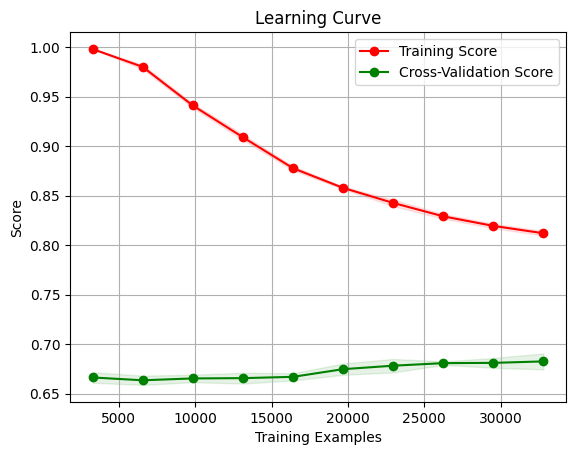

In [115]:
#Learning curve
train_sizes, train_scores, test_scores = learning_curve(ann_clf_best, X, y, cv=5, train_sizes=np.linspace(0.1, 1.0, 10))

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [25]:
#ANN WITHOUT SACLED DATA
param_grid = {
    'hidden_layer_sizes': [(100,), (50, 50), (25, 25, 25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'random_state': [42]
}

ann_clf = MLPClassifier()
grid_search = GridSearchCV(ann_clf, param_grid, cv=5)
#grid_search.fit(X_train, y_train)
grid_search.fit(X, y)

best_params = grid_search.best_params_
ann_clf_best = MLPClassifier(**best_params)
cv_scores = cross_val_score(ann_clf_best, X_train, y_train, cv=5)
ann_clf_best.fit(X_train, y_train)
y_pred = ann_clf_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Parameters:", best_params)
print("Cross-Validation Scores:", cv_scores)
print("Accuracy Score:", accuracy)

C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\salij\A

Best Parameters: {'activation': 'tanh', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'random_state': 42, 'solver': 'adam'}
Cross-Validation Scores: [0.70472561 0.70746951 0.70060976 0.71128049 0.69862805]
Accuracy Score: 0.7042682926829268


C:\Users\salij\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
